In [ ]:
import pandas as pd
import time
from datetime import datetime
from openai import OpenAI
from tqdm import tqdm
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import os
import re
import matplotlib.pyplot as plt
import tiktoken

# --- Configuration ---
LITELLM_PROXY_URL = ""
LITELLM_PROXY_API_KEY = "sk-S4vI4ayBQ6oPE-WSRBBn_g"

client = OpenAI(
    api_key=LITELLM_PROXY_API_KEY,
    base_url=LITELLM_PROXY_URL
)

# Choose the OpenAI model
OPENAI_MODEL = "GPT-4o"

# --- Data Loading and Preprocessing ---
df = pd.read_csv("infoevents1.csv")

DESCRIPTION_COL = "targetbusinessdescription"
SYNOPSIS_COL = "dealsynopsis"

df["category"] = ""
df["explanation"] = ""
df["confidence"] = ""
df["raw_output"] = ""

df["combined_text"] = df[DESCRIPTION_COL].fillna("") + " " + df[SYNOPSIS_COL].fillna("")

# --- Handle date column ---
if "dateannounced" in df.columns:
    df["dateannounced"] = pd.to_datetime(df["dateannounced"], errors="coerce")
    df["deal_year"] = df["dateannounced"].dt.year
else:
    df["deal_year"] = datetime.now().year

df["deal_year"] = df["deal_year"].fillna(df["deal_year"].median())

# --- Advanced Feature Engineering ---
ev_keywords = [
    "electric", "battery", "lithium", "charging", "ev platform", "e-motor",
    "fuel cell", "hybrid electric", "plug-in hybrid", "bms",
    "battery management system", "inverter", "power electronics",
    "new energy vehicle", "electrification", "automobile batteries"
]
def has_ev_keywords(text):
    return any(re.search(r"\b" + keyword + r"\b", text, re.IGNORECASE) for keyword in ev_keywords)

propulsion_keywords = [
    "engine", "motor vehicle manufacturing", "powertrain", "drivetrain",
    "combustion", "diesel", "gasoline", "transmission", "ICEV", "automobiles",
    "trucks", "buses", "motorcycles", "vehicles", "internal combustion",
    "passenger cars"
]
accessory_service_keywords = [
    "dealership", "car rental", "logistics", "telematics", "electronic components",
    "software", "insurance", "real estate", "crm", "marketing", "fleet management"
]

def get_automotive_focus(text):
    text_lower = text.lower()
    is_propulsion = any(keyword in text_lower for keyword in propulsion_keywords)
    is_accessory_service = any(keyword in text_lower for keyword in accessory_service_keywords)

    if is_propulsion and not is_accessory_service:
        return "core propulsion or vehicle manufacturing"
    elif is_accessory_service and not is_propulsion:
        return "general automotive accessory or service (not core propulsion)"
    elif is_propulsion and is_accessory_service:
        return "mix of propulsion and accessory/service"
    else:
        return "general automotive or non-automotive"

df["has_ev_keywords"] = df["combined_text"].apply(has_ev_keywords)
df["automotive_focus"] = df["combined_text"].apply(get_automotive_focus)

# --- Category Definitions ---
CATEGORY_DEFINITIONS = {
    1: "ICEV Support: Deals directly related to the manufacturing, production, or core components of ICE propulsion systems.",
    2: "EV Support: Deals directly related to the manufacturing, production, or core components of EV propulsion systems.",
    3: "Neither: Deals related to general automotive services or components not part of the core propulsion system."
}

# --- Few-shot Examples Block (25 balanced) ---
example_block = """Example 1:
- Desc: Anhui Ankai Automobile Co Ltd is a manufacturer and wholesaler of automobiles.
- Synop: CHINA - Anhui Jianghuai Automobile Group Co Ltd acquired a 28.12% stake in Anhui Ankai Automobile Co Ltd.
EXPLANATION: This company manufactures and wholesales automobiles with no EV mention, making it ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 2:
- Desc: Manufacture motor vehicles
- Synop: Ford Motor Co unit acquired remaining stake in Belgian motor vehicle manufacturer.
EXPLANATION: This is direct manufacturing of combustion motor vehicles, classified as ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 3:
- Desc: Manufacture and wholesale scooters and motorcycles
- Synop: Peugeot Motorcycles acquired to expand two-wheeler business line.
EXPLANATION: Scooters and motorcycles are ICE-based vehicles, making this ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 4:
- Desc: Cold-start injector systems for diesel engines
- Synop: OEM acquisition for combustion reliability in extreme weather.
EXPLANATION: This involves cold-start injector systems for diesel engines, directly supporting combustion engine reliability.
CATEGORY: 1
CONFIDENCE: 95

Example 5:
- Desc: Parts logistics firm for ICE vehicle maintenance
- Synop: OEM acquired to streamline engine-related supply chain.
EXPLANATION: This firm provides parts logistics for ICE vehicle maintenance, streamlining the engine-related supply chain.
CATEGORY: 1
CONFIDENCE: 95

Example 6:
- Desc: Data tool for ICE emission compliance
- Synop: Ensures combustion engine lines meet regulatory norms.
EXPLANATION: This tool assists with ICE emission compliance, ensuring combustion engine lines meet regulatory norms.
CATEGORY: 1
CONFIDENCE: 95

Example 7:
- Desc: Legacy ICE car manufacturer
- Synop: Acquisition to consolidate combustion vehicle production.
EXPLANATION: A legacy OEM focused on ICE production, clearly ICEV Support.
CATEGORY: 1
CONFIDENCE: 95

Example 8:
- Desc: Lithium-ion battery supplier for EVs
- Synop: OEM secured supplier to support electrification pipeline.
EXPLANATION: This company supplies lithium-ion batteries for EVs, a core component for EV propulsion.
CATEGORY: 2
CONFIDENCE: 95

Example 9:
- Desc: EV chassis and frame producer
- Synop: OEM acquisition to scale lightweight EV platforms.
EXPLANATION: This producer focuses on EV chassis and frames, essential for EV platforms.
CATEGORY: 2
CONFIDENCE: 95

Example 10:
- Desc: EV charging network API
- Synop: Used to manage station load balancing and routing.
EXPLANATION: This API manages EV charging networks, directly supporting EV infrastructure.
CATEGORY: 2
CONFIDENCE: 95

Example 11:
- Desc: Inverter and motor controller firm
- Synop: Powers electric powertrains in new vehicle line.
EXPLANATION: Specializes in inverters and motor controllers powering EVs.
CATEGORY: 2
CONFIDENCE: 95

Example 12:
- Desc: Battery module testing system used in EV assembly
- Synop: Enables OEMs to validate battery packs before installation.
EXPLANATION: This system tests EV battery modules, essential for EV assembly.
CATEGORY: 2
CONFIDENCE: 95

Example 13:
- Desc: AI system for battery degradation prediction
- Synop: Software tailored to EV platforms.
EXPLANATION: This AI system predicts battery degradation, tailored to EV platforms.
CATEGORY: 2
CONFIDENCE: 95

Example 14:
- Desc: Smart charger app for home and fleet EVs
- Synop: Manages real-time charging schedules and optimization.
EXPLANATION: This app manages charging schedules, directly supporting EV use.
CATEGORY: 2
CONFIDENCE: 95

Example 15:
- Desc: EV fleet charging scheduler
- Synop: Enables coordinated charging for electric delivery vans.
EXPLANATION: This scheduler coordinates charging for EV fleets.
CATEGORY: 2
CONFIDENCE: 95

Example 16:
- Desc: Smart grid energy optimizer for EV charging
- Synop: Balances load during peak EV usage at stations.
EXPLANATION: This optimizer balances load during peak EV charging, supporting EV adoption.
CATEGORY: 2
CONFIDENCE: 95

Example 17:
- Desc: EV retrofit kit provider for converting ICE fleets
- Synop: OEM funds conversion to electric drivetrains.
EXPLANATION: Provides retrofit kits converting ICE fleets to EVs.
CATEGORY: 2
CONFIDENCE: 95

Example 18:
- Desc: Electric utility vehicles
- Synop: Manufacturer acquired for electric utility vehicle production.
EXPLANATION: Explicitly focuses on electric utility vehicles, classified as EV Support.
CATEGORY: 2
CONFIDENCE: 95

Example 19:
- Desc: CRM platform for dealerships
- Synop: SaaS for sales analytics, not tied to vehicle systems.
EXPLANATION: A dealership CRM unrelated to propulsion systems, classified as Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 20:
- Desc: Automotive ad-tech firm
- Synop: Helps OEMs run promotions, no role in propulsion.
EXPLANATION: Provides advertising solutions for OEMs, not propulsion, classified as Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 21:
- Desc: B2C car rental app
- Synop: Helps users compare prices and book cars.
EXPLANATION: A general consumer service for car rentals, not propulsion-related, so Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 22:
- Desc: Logistics routing platform for last-mile delivery
- Synop: Focused on delivery software.
EXPLANATION: Provides logistics routing, unrelated to propulsion, so Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 23:
- Desc: Vehicle pricing insights API for dealerships
- Synop: SaaS providing price comparison and lead generation tools.
EXPLANATION: Provides pricing insights for dealerships, unrelated to propulsion, so Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 24:
- Desc: Electric utility company
- Synop: Acquisition of regional power provider to manage energy supply.
EXPLANATION: A utility company unrelated to vehicle propulsion, so Neither.
CATEGORY: 3
CONFIDENCE: 95

Example 25:
- Desc: Service partner for electronic components across industries.
- Synop: OEM partners for general electronic components.
EXPLANATION: Provides general components across industries, not propulsion, so Neither.
CATEGORY: 3
CONFIDENCE: 95
"""

# --- Classification Function ---
def get_openai_classification(text_description, deal_synopsis, deal_year, has_ev_keywords_flag, automotive_focus_type, row_sdcdealno=None):
    system_message_content = (
        "You are an expert consultant specializing in the automotive industry's investment landscape. "
        "Classify a given deal into one of three distinct categories: 1 (ICEV Support), 2 (EV Support), or 3 (Neither).\n\n"
    )
    for cat_num, desc in CATEGORY_DEFINITIONS.items():
        system_message_content += f"Category {cat_num}: {desc}\n"
    system_message_content += "\nHere are diverse examples:\n\n"
    system_message_content += example_block + "\n--- End Examples ---\n\n"

    user_message_content = (
        f"Now, classify this deal. Provide a concise explanation (30-60 words), then the CATEGORY, and CONFIDENCE.\n"
        f"Description: '''{text_description}'''\n"
        f"Deal Synopsis: '''{deal_synopsis}'''\n"
        f"Date Announced: {int(deal_year)}\n"
        f"Analyzed features: EV Keywords: {'Yes' if has_ev_keywords_flag else 'No'}, Focus: {automotive_focus_type}\n\n"
        f"EXPLANATION:\nCATEGORY: [1/2/3/NA]\nCONFIDENCE: [1-100]\n"
    )

    try:
        response = client.chat.completions.create(
            model=OPENAI_MODEL,
            messages=[
                {"role": "system", "content": system_message_content},
                {"role": "user", "content": user_message_content}
            ],
            temperature=0,
            max_tokens=200
        )
        content = response.choices[0].message.content.strip() if response.choices else ""

        parsed_category = "NA"
        parsed_confidence = 0
        parsed_explanation = ""

        if content:
            lines = content.splitlines()
            current_section = None
            for line in lines:
                line = line.strip()
                if line.upper().startswith("EXPLANATION:"):
                    current_section = "EXPLANATION"
                    parsed_explanation += line[len("EXPLANATION:"):].strip() + " "
                elif line.upper().startswith("CATEGORY:"):
                    current_section = "CATEGORY"
                    value = line[len("CATEGORY:"):].strip()
                    if value.isdigit() and int(value) in {1, 2, 3}:
                        parsed_category = int(value)
                    elif value.upper() == "NA":
                        parsed_category = "NA"
                elif line.upper().startswith("CONFIDENCE:"):
                    current_section = "CONFIDENCE"
                    value = line[len("CONFIDENCE:"):].strip()
                    if value.isdigit():
                        parsed_confidence = int(value)
                elif current_section == "EXPLANATION":
                    parsed_explanation += line + " "

            parsed_explanation = parsed_explanation.strip()

        return {
            "category": parsed_category,
            "confidence": parsed_confidence,
            "explanation": parsed_explanation,
            "raw_output": content
        }

    except Exception as e:
        return {
            "category": "error",
            "confidence": 0,
            "explanation": str(e),
            "raw_output": f"API Error: {e}"
        }

# --- Tokenizer Setup ---
try:
    model_name_lower = OPENAI_MODEL.lower()
    if model_name_lower == "gpt-4o" or model_name_lower == "gpt-4o-mini":
        enc = tiktoken.get_encoding("o200k_base")
    else:
        enc = tiktoken.get_encoding("cl100k_base")
except KeyError:
    enc = tiktoken.get_encoding("cl100k_base")

# --- Main Loop ---
df["tokens_used"] = 0
for i, row in tqdm(df.iterrows(), total=len(df)):
    current_description = str(row.get(DESCRIPTION_COL, "") or "")
    current_synopsis = str(row.get(SYNOPSIS_COL, "") or "")
    current_deal_year = row["deal_year"]
    current_has_ev_keywords = row["has_ev_keywords"]
    current_automotive_focus = row["automotive_focus"]

    user_input = current_description + " " + current_synopsis
    estimated_tokens = len(enc.encode(user_input))
    df.at[i, "tokens_used"] = estimated_tokens

    result = get_openai_classification(
        text_description=current_description,
        deal_synopsis=current_synopsis,
        deal_year=current_deal_year,
        has_ev_keywords_flag=current_has_ev_keywords,
        automotive_focus_type=current_automotive_focus,
        row_sdcdealno=row.get("sdcdealno", "N/A")
    )

    df.at[i, "category"] = result["category"]
    df.at[i, "confidence"] = result["confidence"]
    df.at[i, "explanation"] = result["explanation"]
    df.at[i, "raw_output"] = result["raw_output"]

    time.sleep(1.2)

# --- Save Results ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"infoevents1_with_predictions_{timestamp}.csv"
df.to_csv(filename, index=False)
print(f"Saved predictions to {filename}")


100%|██████████| 1476/1476 [1:00:59<00:00,  2.48s/it]

Saved predictions to infoevents1_with_predictions_20250930_154656.csv


Pred rows: 1476  | pred valid 1/2/3: 1468
Unique pred deal_ids: 1476  | valid 1/2/3: 1468
Solution rows: 308  | unique sol deal_ids: 308
Merged rows: 303


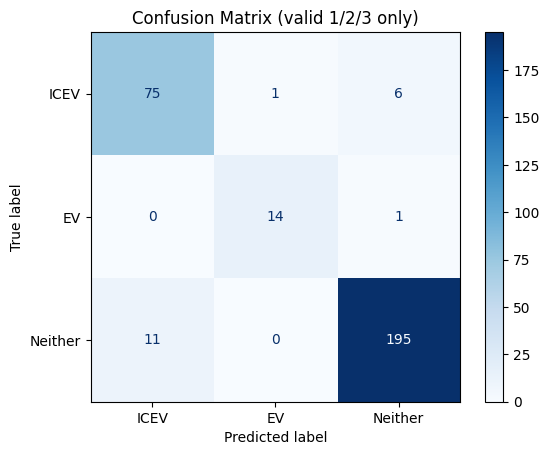

Accuracy: 0.9372937293729373
              precision    recall  f1-score   support

        ICEV     0.8721    0.9146    0.8929        82
          EV     0.9333    0.9333    0.9333        15
     Neither     0.9653    0.9466    0.9559       206

    accuracy                         0.9373       303
   macro avg     0.9236    0.9315    0.9274       303
weighted avg     0.9385    0.9373    0.9377       303



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score

# --- paths (adjust if needed) ---
pred_path = "infoevents1_with_predictions_20250930_154656.csv"
sol_path  = "infoevents1sol.xlsx"

# --- load ---
df_pred = pd.read_csv(pred_path)
sol_df  = pd.read_excel(sol_path)

# --- normalize id columns ---
# predictions: prefer sdcdealno -> deal_id
if "deal_id" in df_pred.columns:
    pass
elif "sdcdealno" in df_pred.columns:
    df_pred = df_pred.rename(columns={"sdcdealno": "deal_id"})
else:
    raise ValueError("Pred file missing 'sdcdealno'/'deal_id' column. Columns: " + ", ".join(df_pred.columns))

# solutions: prefer sdcdealno -> deal_id
if "deal_id" in sol_df.columns:
    pass
elif "sdcdealno" in sol_df.columns:
    sol_df = sol_df.rename(columns={"sdcdealno": "deal_id"})
else:
    raise ValueError("Solutions file missing 'sdcdealno'/'deal_id'. Columns: " + ", ".join(sol_df.columns))

# --- coerce prediction categories to numeric and keep only 1/2/3 ---
df_pred["category_num"] = pd.to_numeric(df_pred["category"], errors="coerce")
df_pred_valid = df_pred[df_pred["category_num"].isin([1, 2, 3])].copy()

# --- diagnostics before merge ---
print("Pred rows:", len(df_pred), " | pred valid 1/2/3:", len(df_pred_valid))
print("Unique pred deal_ids:", df_pred["deal_id"].nunique(), " | valid 1/2/3:", df_pred_valid["deal_id"].nunique())
print("Solution rows:", len(sol_df), " | unique sol deal_ids:", sol_df["deal_id"].nunique())
if len(df_pred_valid) == 0:
    print("All predictions are NA/invalid (not in {1,2,3}). Nothing to evaluate.")

# --- merge on deal_id ---
merged = pd.merge(
    df_pred_valid[["deal_id", "category_num"]],
    sol_df[["deal_id", "categorysol"]],
    on="deal_id",
    how="inner"
)

print("Merged rows:", len(merged))
if len(merged) == 0:
    # help troubleshoot
    pred_ids = set(df_pred_valid["deal_id"].astype(str))
    sol_ids  = set(sol_df["deal_id"].astype(str))
    inter    = pred_ids & sol_ids
    print("Overlap in IDs:", len(inter))
    sample_pred_only = list(pred_ids - sol_ids)[:5]
    sample_sol_only  = list(sol_ids - pred_ids)[:5]
    print("Sample pred-only IDs:", sample_pred_only)
    print("Sample sol-only IDs:", sample_sol_only)

# --- proceed only if we have rows ---
if len(merged) > 0:
    # keep only solution labels 1/2/3
    merged = merged[merged["categorysol"].isin([1, 2, 3])].copy()
    if len(merged) == 0:
        print("After filtering solution labels to {1,2,3}, no rows remain.")
    else:
        y_true = merged["categorysol"].astype(int).to_numpy()
        y_pred = merged["category_num"].astype(int).to_numpy()

        # Confusion matrix (works even if a class is missing in preds; we force labels)
        labels = [1, 2, 3]
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ICEV", "EV", "Neither"])
        disp.plot(cmap="Blues")
        plt.title("Confusion Matrix (valid 1/2/3 only)")
        plt.show()

        # Classification report (force labels + names; handle zero divisions)
        print("Accuracy:", accuracy_score(y_true, y_pred))
        print(classification_report(
            y_true, y_pred,
            labels=labels,
            target_names=["ICEV", "EV", "Neither"],
            digits=4,
            zero_division=0
        ))
else:
    print("No rows to evaluate. See diagnostics above.")
